# "[Kaggle] Otto Group"
> "Feature가 명확하지 않음"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Rauk
- categories: [SSUDA, Machine Learning]

## Data fields
- id - an anonymous id unique to a product
- feat_1, feat_2, ..., feat_93 - the various features of a product
- target - the class of a product

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c otto-group-product-classification-challenge

  0% 0.00/369k [00:00<?, ?B/s]
100% 369k/369k [00:00<00:00, 51.7MB/s]
  0% 0.00/4.00M [00:00<?, ?B/s]
100% 4.00M/4.00M [00:00<00:00, 65.4MB/s]
  0% 0.00/1.69M [00:00<?, ?B/s]
100% 1.69M/1.69M [00:00<00:00, 53.9MB/s]


In [ ]:
!unzip sampleSubmission.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


## CODING

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
train = pd.read_csv('train.csv')
train.head(7)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,4,1,1,0,0,2,0,0,0,0,0,1,0,0,0,0,...,0,0,2,0,0,11,0,1,1,0,1,0,7,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,7,2,2,0,0,0,58,0,10,0,0,0,0,0,3,0,...,1,0,0,0,0,0,0,0,0,0,2,1,5,0,0,4,0,0,2,1,0,1,0,0,1,1,2,2,0,22,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,4,0,1,0,0,0,1,0,0,0,0,1,0,0,0,Class_1
5,6,2,1,0,0,7,0,0,0,0,0,0,0,2,0,0,0,6,0,0,2,0,0,0,5,0,0,0,0,1,0,0,2,0,0,0,2,0,0,0,...,0,0,0,0,0,5,0,1,0,1,4,2,6,0,2,4,2,0,0,1,0,2,0,4,3,0,0,0,0,1,0,3,0,0,0,0,2,0,0,Class_1
6,7,2,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2,2,0,0,0,0,0,0,1,0,2,...,2,0,0,0,0,2,0,1,0,3,1,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,Class_1


In [ ]:
test = pd.read_csv('test.csv')
test.head(7)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,...,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,3,2,1,0,0,0,0,0,0,0,5,3,1,1,0,0,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,20,0,0,0,0,0
1,2,2,2,14,16,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,2,0,4,0,4,0,0,0,0,2,0,0,0,8,0,0,0,0,...,24,0,0,0,0,0,0,0,0,0,6,8,0,0,0,0,0,0,0,0,0,0,0,2,0,0,4,0,2,0,0,0,0,0,0,4,0,0,2,0
2,3,0,1,12,1,0,0,0,0,0,0,7,1,0,0,0,7,0,2,0,0,0,4,0,0,0,1,1,2,0,0,0,0,0,0,1,0,0,2,0,...,10,1,0,2,0,0,1,6,1,1,0,0,1,1,1,2,0,0,2,0,0,0,0,0,0,0,6,0,2,0,0,0,0,0,2,0,0,0,0,1
3,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,21,3,0,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,2,0,0,0,0,1,0,...,2,0,0,0,0,0,0,0,9,0,0,2,0,0,0,0,6,0,8,0,0,0,0,1,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,1,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,4,0,5,16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9,0,0
5,6,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0,0,0,0,0,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,11,0,0,7,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,5,0,0,0,1,0,4,0,1,0,4,0,2,0,0,1,0,0,1,0,0,1,0,0,0,2,0,2,1,1,...,1,0,1,1,0,1,0,0,2,0,0,2,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0,2,0,3,0,0,1,0,18,1,0,0


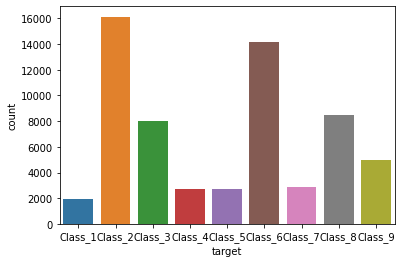

In [ ]:
sns.countplot(x = train.target)

In [ ]:
class_to_order = dict()
order_to_class = dict()

for idx, col in enumerate(train.target.unique()):
    order_to_class[idx] = col
    class_to_order[col] = idx

train["target_ord"] = train["target"].map(class_to_order).astype("int16")
feature_columns = [col for col in train.columns if col.startswith("feat_")]
target_column = ["target_ord"]

In [ ]:
order_to_class

{0: 'Class_1',
 1: 'Class_2',
 2: 'Class_3',
 3: 'Class_4',
 4: 'Class_5',
 5: 'Class_6',
 6: 'Class_7',
 7: 'Class_8',
 8: 'Class_9'}

In [ ]:
class_to_order

{'Class_1': 0,
 'Class_2': 1,
 'Class_3': 2,
 'Class_4': 3,
 'Class_5': 4,
 'Class_6': 5,
 'Class_7': 6,
 'Class_8': 7,
 'Class_9': 8}

## Skewness

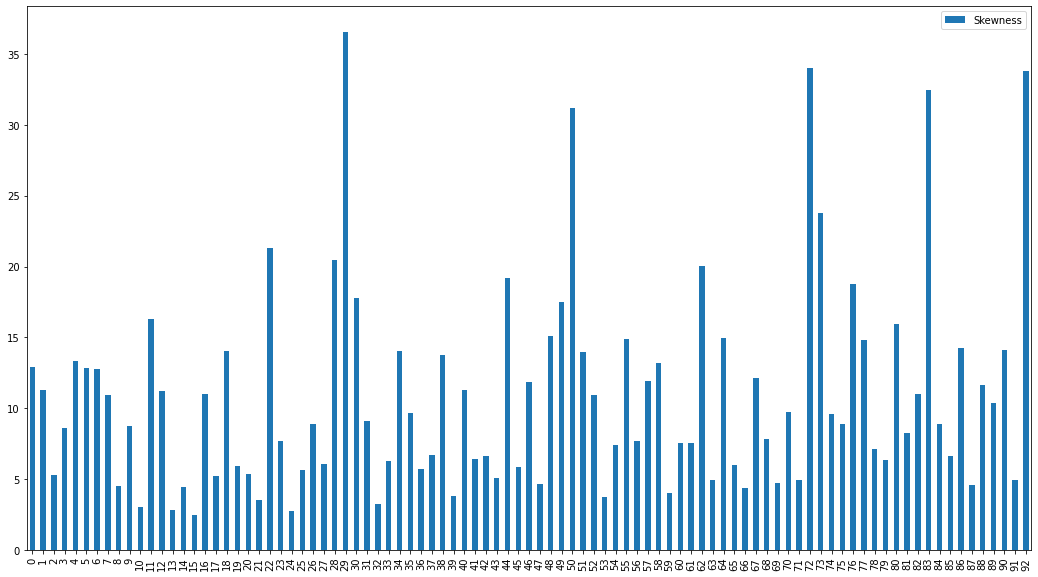

In [ ]:
skew = []
for i in train[feature_columns].columns:
    skew.append(train[str(i)].skew())
    
skew_df = pd.DataFrame({'Feature': train[feature_columns].columns, 'Skewness': skew})
skew_df.plot(kind='bar',figsize=(18,10))

## Quantile Transformer
- We are now going to apply the QuantileTransformer from scikit-learn. I first used StandardScaler but found that there was no change in the skew value of the features.
- QuantileTransformer는 각 형상의 확률 밀도 함수가 균등 또는 가우스 분포에 매핑되도록 비선형 변환을 적용한다. 이 경우, 특이치를 포함한 모든 데이터는 [0,1] 범위의 균등 분포에 매핑되어 특이치와 inlier를 구분할 수 없게 됩니다.
- 기본적으로 1000개 분위를 사용하여 데이터를 '균등분포' 시킵니다.Robust처럼 이상치에 민감X, 0~1사이로 압축합니다. -> 이후 output_distribution='normal'을 적용하면 정규분포형태의 값으로 나타난다.

- RobustScaler와 QuantileTransformer는 훈련 세트에서 특이치를 추가하거나 제거하면 거의 동일한 변환을 얻을 수 있다는 점에서 특이치에 강하다. 그러나 RobustScaler와 반대로 QuantileTransformer는 또한 이상치를 사전 정의된 범위 경계(0 및 1)로 설정하여 자동으로 축소한다. 이로 인해 극단값의 포화 아티팩트가 발생할 수 있습니다.

In [ ]:
from sklearn.preprocessing import QuantileTransformer
train[feature_columns] = QuantileTransformer(copy=False, output_distribution='normal').fit_transform(train[feature_columns])
test[feature_columns] = QuantileTransformer(copy=False, output_distribution='normal').fit_transform(test[feature_columns])

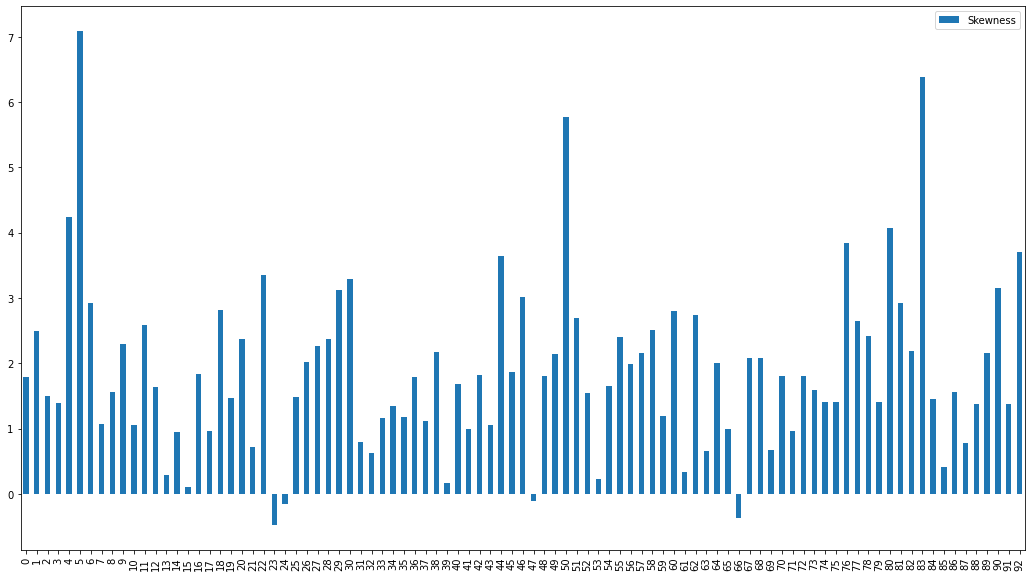

In [ ]:
# 조정 후 Skewness
skew = []
for i in train[feature_columns].columns:
    skew.append(train[str(i)].skew())
    
skew_df = pd.DataFrame({'Feature': train[feature_columns].columns, 'Skewness': skew})
skew_df.plot(kind='bar',figsize=(18,10))

In [ ]:
# check features for skew
skew_feats = train[feature_columns].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_feats})
skewness = skewness[abs(skewness) > 3.75].dropna()
skewed_features = skewness.index.values.tolist()
skewed_features

['feat_6', 'feat_84', 'feat_51', 'feat_5', 'feat_81', 'feat_77']

In [ ]:
train_new = train.drop(skewed_features, axis = 1)
train_new

,id,feat_1,feat_2,feat_3,feat_4,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,...,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_78,feat_79,feat_80,feat_82,feat_83,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target,target_ord
0,1,1.174387,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.779924,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.644369,-5.199338,-5.199338,-5.199338,-5.199338,0.651824,-5.199338,0.833781,0.152391,1.004131,-5.199338,-5.199338,1.934489,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.983573,-5.199338,-5.199338,-5.199338,-5.199338,0.304482,-5.199338,...,-5.199338,0.287442,-5.199338,-5.199338,1.649237,-5.199338,-5.199338,1.780005,-5.199338,0.434861,1.541796,-5.199338,1.312981,-5.199338,1.199766,-5.199338,-5.199338,-5.199338,1.207532,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.721914,0.969427,-5.199338,-5.199338,1.027247,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,Class_1,0
1,2,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.869846,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.310017,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.223287,-5.199338,-5.199338,-5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.266860,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.642543,-5.199338,-5.199338,-0.084155,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.615945,1.072973,-5.199338,0.997920,1.467860,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,Class_1,0
2,3,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.869846,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.202347,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.644086,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,-5.199338,-5.199338,1.157061,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.046576,-5.199338,-5.199338,1.027247,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,Class_1,0
3,4,1.174387,-5.199338,-5.199338,0.959440,2.432017,-5.199338,-5.199338,1.355761,0.779924,-5.199338,1.128144,-5.199338,-5.199338,0.253606,1.202347,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.295363,0.636387,1.340200,-5.199338,-5.199338,-5.199338,3.365547,-5.199338,2.325972,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.634747,-5.199338,-5.199338,-5.199338,...,-5.199338,0.803958,1.157061,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.926403,0.819656,0.888309,-5.199338,-5.199338,1.562721,-5.199338,-5.199338,1.615945,1.072973,-5.199338,0.997920,-5.199338,1.365257,0.969427,1.851734,-5.199338,-5.199338,0.485069,1.644369,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,Class_1,0
4,5,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,2.074445,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-0.118204,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.1

## Train_test 분리

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

X_train, X_valid, y_train, y_valid = train_test_split(
    train_new.drop(['id', 'target', 'target_ord'], axis = 1), 
    train_new[target_column],
    test_size = 0.275, 
    random_state = 7, 
    stratify = train_new[target_column]
)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors = 25, weights = 'distance')
knc.fit(X_train, y_train)
yhat = knc.predict(X_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

result = confusion_matrix(y_valid, yhat)
print("Confusion Matrix:")
print(result)

Confusion Matrix:
[[ 120   50    5    0   45   44    3  103  160]
 [   2 3891  461   11   36    9   10    8    6]
 [   0 1234  928   11    3    6    7   10    2]
 [   1  452  129  123   10   14    5    2    4]
 [   0   29    3    0  719    1    0    0    1]
 [  11  124   12    5   48 3514   21   72   80]
 [  11  195   95    1   33   59  320   55   12]
 [  14  113    8    0   54  152    7 1913   67]
 [   8  129    7    0   39   47    5   45 1083]]


In [ ]:
result1 = classification_report(y_valid, yhat)
print("Classification Report:")
print(result1)

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.23      0.34       530
           1       0.63      0.88      0.73      4434
           2       0.56      0.42      0.48      2201
           3       0.81      0.17      0.28       740
           4       0.73      0.95      0.83       753
           5       0.91      0.90      0.91      3887
           6       0.85      0.41      0.55       781
           7       0.87      0.82      0.84      2328
           8       0.77      0.79      0.78      1363

    accuracy                           0.74     17017
   macro avg       0.76      0.62      0.64     17017
weighted avg       0.75      0.74      0.72     17017



In [ ]:
yhat_KNN = knc.predict_proba(X_valid)
logloss_KNN = log_loss(y_valid, yhat_KNN)
print('Log loss using KNN classifier:', logloss_KNN)

Log loss using KNN classifier: 1.2113082274705085


## Support Vector Machine

In [ ]:
from sklearn import svm

svm = svm.SVC(kernel = 'rbf', probability = True, random_state = 7)
svm.fit(X_train, y_train)

yhat = svm.predict(X_valid)
yhat_svm = svm.predict_proba(X_valid)
logloss_svm = log_loss(y_valid, yhat_svm)
print('Logloss using Support Vector Machines:', logloss_svm)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
cnf_matrix = confusion_matrix(y_valid, yhat, labels = train_new.target_ord.unique().tolist())

plt.figure()
plot_confusion_matrix(cnf_matrix, classes = train_new.target.unique().tolist())

In [ ]:
print('Classification Report:')
print(classification_report(y_valid, yhat))

## Catboost

In [ ]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.4 MB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
CBC_params = {
                'iterations': 5000, 
                'od_wait': 250,
                'use_best_model': True,
                'loss_function': 'MultiClass',
                'eval_metric': 'MultiClass',
                'leaf_estimation_method': 'Newton',
                'bootstrap_type': 'Bernoulli',
                'subsample': 0.5,
                'learning_rate': 0.08,
                'l2_leaf_reg': 0.4, #L2 Regularization
                'random_strength': 10, #amount of randomness to use for scoring splits when tree structure is selected
                'depth': 7, #Tree depth
                'min_data_in_leaf': 3, #minimum number of training samples in a leaf
                'leaf_estimation_iterations': 4, #Earlier = 7
                'task_type': 'GPU',
                'border_count': 128, #Number of splits for numerical features
            }

In [ ]:
cbc = CatBoostClassifier(**CBC_params)
cbc.fit(X_train, y_train,
       eval_set = [(X_valid, y_valid)],
       early_stopping_rounds = 100,
       )

0:	learn: 2.0121432	test: 2.0116864	best: 2.0116864 (0)	total: 56.9ms	remaining: 4m 44s
1:	learn: 1.8642747	test: 1.8644735	best: 1.8644735 (1)	total: 98.4ms	remaining: 4m 5s
2:	learn: 1.7692236	test: 1.7704969	best: 1.7704969 (2)	total: 146ms	remaining: 4m 2s
3:	learn: 1.6593988	test: 1.6598242	best: 1.6598242 (3)	total: 185ms	remaining: 3m 51s
4:	learn: 1.5631640	test: 1.5640647	best: 1.5640647 (4)	total: 224ms	remaining: 3m 43s
5:	learn: 1.4930563	test: 1.4943294	best: 1.4943294 (5)	total: 264ms	remaining: 3m 39s
6:	learn: 1.4217600	test: 1.4245219	best: 1.4245219 (6)	total: 303ms	remaining: 3m 36s
7:	learn: 1.3784399	test: 1.3820308	best: 1.3820308 (7)	total: 343ms	remaining: 3m 33s
8:	learn: 1.3193321	test: 1.3238905	best: 1.3238905 (8)	total: 379ms	remaining: 3m 30s
9:	learn: 1.2804642	test: 1.2863043	best: 1.2863043 (9)	total: 426ms	remaining: 3m 32s
10:	learn: 1.2379976	test: 1.2440289	best: 1.2440289 (10)	total: 471ms	remaining: 3m 33s
11:	learn: 1.2071237	test: 1.2131275	best

In [ ]:
yhat_CBC = cbc.predict_proba(X_valid)
logloss_CBC = log_loss(y_valid, yhat_CBC)
print('Log loss using CatBoost Classifier:', logloss_CBC)

Log loss using CatBoost Classifier: 0.4887160745223992


## Submission

In [ ]:
submission = pd.read_csv("sampleSubmission.csv")

In [ ]:
test.drop(skewed_features, axis = 1, inplace = True)
test.drop("id", axis = 1)

,feat_1,feat_2,feat_3,feat_4,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,...,feat_50,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_78,feat_79,feat_80,feat_82,feat_83,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,2.023292,-5.199338,-5.199338,-5.199338,0.888309,1.104747,0.252311,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.020888,0.945616,1.012474,1.159515,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.634851,-5.199338,-5.199338,0.890172,-5.199338,0.864365,-5.199338,0.303168,-5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.283836,-5.199338,-5.199338,-5.199338,-5.199338,1.239352,0.604448,-5.199338,0.800496,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,2.241016,1.107059,3.089935,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
1,1.575613,1.792374,2.241016,2.511791,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.104747,0.644086,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.100140,-5.199338,0.835558,-5.199338,1.761948,-5.199338,-5.199338,-5.199338,-5.199338,2.063775,-5.199338,-5.199338,-5.199338,2.241016,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,2.611712,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.554270,3.090775,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.625274,1.837975,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,2.023292,-5.199338,-5.199338,1.562721,-5.199338
2,-5.199338,1.411293,2.085356,0.961429,-5.199338,-5.199338,-5.199338,-5.199338,1.401177,1.521525,-5.199338,-5.199338,-5.199338,1.805023,-5.199338,1.304121,-5.199338,-5.199338,-5.199338,1.750222,-5.199338,-5.199338,-5.199338,1.012474,1.159515,1.756055,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.979511,-5.199338,-5.199338,1.318946,-5.199338,-5.199338,-5.199338,0.819656,...,-5.199338,-5.199338,-5.199338,1.625274,1.147315,-5.199338,1.649237,-5.199338,-5.199338,0.890172,2.408550,0.437620,1.529558,-5.199338,-5.199338,0.817902,-0.085414,1.280981,1.541796,-5.199338,-5.199338,1.225943,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.858747,1.837975,-5.199338,-5.199338,-5.199338,-5.199338,1.116369,-5.199338,-5.199338,-5.199338,-5.199338,1.756055
3,-5.199338,-5.199338,-5.199338,0.961429,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,2.256745,0.943656,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.194628,-5.199338,-5.199338,-5.199338,1.425011,-5.199338,-5.199338,-5.199338,1.157061,-5.199338,-5.199338,-5.199338,-5.199338,0.864365,-5.199338,-5.199338,1.780005,-5.199338,...,-5.199338,-5.199338,-5.199338,0.593940,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,2.085356,-5.199338,-5.199338,1.895259,-5.199338,-5.199338,-5.199338,-5.199338,1.926403,-5.199338,1.918441,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.684464,0.487893,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
4,1.166919,-5.199338,-5.199338,0.961429,1.533612,1.349498,-5.199338,2.023292,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.835558,-5.

In [ ]:
pred = cbc.predict_proba(test.drop("id", axis = 1))

In [ ]:
res = pd.concat([pd.DataFrame(test.id.copy()), pd.DataFrame(pred)], axis = 1)

In [ ]:
res.columns = submission.columns
res

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,2.035351e-05,4.155254e-01,3.875593e-01,1.915983e-01,2.915440e-07,1.226470e-05,0.005280,4.166429e-06,4.079353e-07
1,2,1.044036e-03,1.270427e-03,4.121220e-05,5.418426e-05,2.820285e-05,8.437974e-01,0.001460,1.520497e-01,2.549993e-04
2,3,2.135121e-05,9.982301e-07,8.321858e-08,7.266236e-07,2.065122e-08,9.990895e-01,0.000011,8.304871e-04,4.548511e-05
3,4,4.848869e-07,4.703883e-01,5.147936e-01,1.479793e-02,2.397874e-08,4.605196e-07,0.000002,9.831731e-07,1.593111e-05
4,5,2.125766e-01,5.142562e-06,4.496004e-06,2.344188e-07,7.721577e-06,2.403795e-03,0.002119,9.924007e-02,6.836430e-01
...,...,...,...,...,...,...,...,...,...,...
144363,144364,1.150385e-01,7.801859e-03,2.000100e-03,8.358705e-03,9.410110e-06,6.613778e-01,0.057846,3.151485e-02,1.160532e-01
144364,144365,6.608930e-06,2.086875e-01,5.610609e-01,2.138117e-01,5.130627e-07,7.407528e-06,0.016423,1.153003e-06,8.949993e-07
144365,144366,1.019279e-05,8.252583e-01,1.191019e-01,5.058851e-02,7.644276e-07,5.194041e-05,0.004964,1.954108e-05,4.841306e-06
144366,144367,4.536330e-06,4.586519e-01,2.200562e-02,5.193098e-01,1.357773e-06,5.442924e-07,0.000025,1.044206e-06,1.014232e-07


In [ ]:
res.to_csv("submission.csv", index = False)

In [ ]:
!kaggle competitions submit -c otto-group-product-classification-challenge -f submission.csv -m "Message"

100% 27.4M/27.4M [00:01<00:00, 15.4MB/s]
Successfully submitted to Otto Group Product Classification Challenge